# Machine Learning

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import random

In [45]:
# Load our existing fire data
fire_data = pd.read_csv('../data/processed/cleaned_data_final.csv', low_memory=False)

# Create a function to generate random points within California bounds
def generate_random_points(n_points, ca_bounds):
    """
    Generate random points within California bounds
    ca_bounds should be (min_lat, max_lat, min_lon, max_lon)
    """
    min_lat, max_lat, min_lon, max_lon = ca_bounds
    points = []
    
    for _ in range(n_points):
        lat = random.uniform(min_lat, max_lat)
        lon = random.uniform(min_lon, max_lon)
        points.append([lat, lon])
    
    return pd.DataFrame(points, columns=['LATITUDE', 'LONGITUDE'])

# California approximate bounds
ca_bounds = (32.5, 42.0, -124.4, -114.1)

# Generate equal number of non-fire points
n_fires = len(fire_data)
non_fire_points = generate_random_points(n_fires, ca_bounds)

# Add environmental and transmission line data to non-fire points
# (Similar process as we did for fire points)

# Create target variable (1 for fire, 0 for non-fire)
fire_data['is_fire'] = 1
non_fire_points['is_fire'] = 0

# Combine datasets
full_dataset = pd.concat([
    fire_data[['LATITUDE', 'LONGITUDE', 'is_fire', 'nearby_line_count', 
               'min_distance_to_line', 'avg_voltage', 'air', 'soilm', 'vwnd', 
               'EVI_max', 'EVI_mean', 'NDVI_max', 'NDVI_mean']],
    non_fire_points
], ignore_index=True)

print("Shape of combined dataset:", full_dataset.shape)
print("\nClass distribution:")
print(full_dataset['is_fire'].value_counts(normalize=True))

Shape of combined dataset: (367768, 13)

Class distribution:
is_fire
1    0.5
0    0.5
Name: proportion, dtype: float64


In [49]:
print(full_dataset.head())

    LATITUDE   LONGITUDE  is_fire  nearby_line_count  min_distance_to_line  \
0  40.036944 -121.005833        1                1.0             -0.519740   
1  38.933056 -120.404444        1                1.0              2.670609   
2  38.984167 -120.735556        1                1.0             -0.519740   
3  38.559167 -119.913333        1                0.0                   NaN   
4  38.559167 -119.933056        1                0.0                   NaN   

   avg_voltage       air     soilm      vwnd       EVI_max      EVI_mean  \
0    -0.641124 -1.977491  0.426139  1.030781  5.551115e-16  2.775558e-17   
1     1.173118 -0.511032  0.184300  1.160834  5.551115e-16  2.775558e-17   
2     1.173118 -1.799577  0.663682  2.276172  5.551115e-16  2.775558e-17   
3          NaN -2.488807 -0.177192  1.390832  5.551115e-16  2.775558e-17   
4          NaN -2.488807 -0.177192  1.390832  5.551115e-16  2.775558e-17   

   NDVI_max     NDVI_mean  
0       0.0  2.220446e-16  
1       0.0  2.220

In [47]:
import os
from codecarbon import EmissionsTracker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Load the dataset
data = pd.read_csv('../data/processed/grid_fire_data_corrected_cleaned.csv')

# Define Features and Target
features = [
    'air', 'soilm', 'vwnd', 'EVI_max', 'EVI_mean', 'NDVI_max', 'NDVI_mean',
    'kV_Sort', 'Length_Mile', 'line_age_years', 'is_operational', 'is_overhead',
    'nearby_line_count', 'nearby_total_length', 'nearby_avg_voltage', 
    'nearby_max_voltage', 'maintenance_frequency'
]
target = 'had_fire'

X = data[features]
y = data[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

output_dir = "emissions_logs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

tracker = EmissionsTracker(output_dir=output_dir, log_level="info")
tracker.start()

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Train XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="auc", scale_pos_weight=3)
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate Random Forest
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)
rf_roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)
rf_feature_importances = sorted(zip(features, rf_model.feature_importances_), key=lambda x: x[1], reverse=True)

# Evaluate XGBoost
xgb_report = classification_report(y_test, y_pred_xgb, output_dict=True)
xgb_roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)
xgb_conf_matrix = confusion_matrix(y_test, y_pred_xgb)
xgb_feature_importances = sorted(zip(features, xgb_model.feature_importances_), key=lambda x: x[1], reverse=True)

emissions_data = tracker.stop()

# Print the total CO2 emissions
print("\nCarbon Emissions Summary:")
if emissions_data is not None:
    print(f"Total CO2 emissions (kg): {emissions_data:.4f}")
else:
    print("Emissions data not available. Please check the tracker logs.")


[codecarbon INFO @ 21:44:45] [setup] RAM Tracking...
[codecarbon INFO @ 21:44:45] [setup] GPU Tracking...
[codecarbon INFO @ 21:44:45] No GPU found.
[codecarbon INFO @ 21:44:45] [setup] CPU Tracking...
[codecarbon WARNING @ 21:44:45] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 21:44:45] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 21:44:45] >>> Tracker's metadata:
[codecarbon INFO @ 21:44:45]   Platform system: macOS-15.1.1-arm64-arm-64bit
[codecarbon INFO @ 21:44:45]   Python version: 3.12.7
[codecarbon INFO @ 21:44:45]   CodeCarbon version: 2.8.1
[codecarbon INFO @ 21:44:45]   Available RAM : 16.000 GB
[codecarbon INFO @ 21:44:45]   CPU count: 8
[codecarbon INFO @ 21:44:45]   CPU model: Apple M1 Pro
[codecarbon INFO @ 21:44:45]   GPU count: None
[codecarbon INFO @ 21:44:45]   GPU model: None
[codecarbon INFO @ 21:44:49] Saving emissions


Carbon Emissions Summary:
Total CO2 emissions (kg): 0.0000


Random Forest Model Results

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      3819
           1       0.66      0.93      0.77       978

    accuracy                           0.89      4797
   macro avg       0.82      0.90      0.85      4797
weighted avg       0.92      0.89      0.90      4797


ROC-AUC Score: 0.9595545574249086


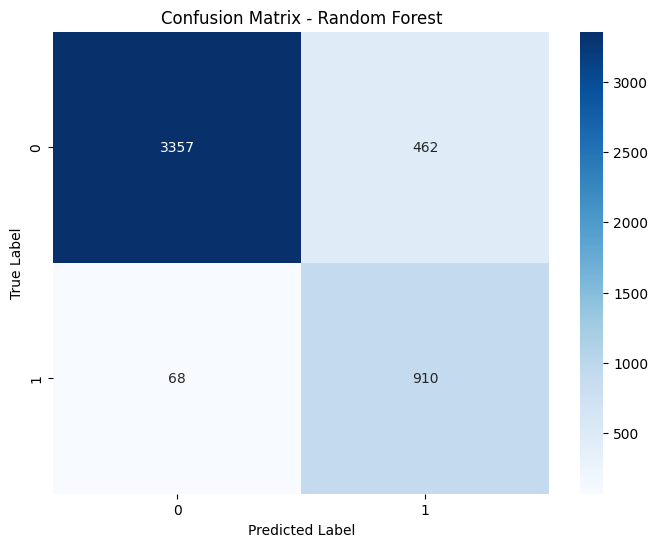

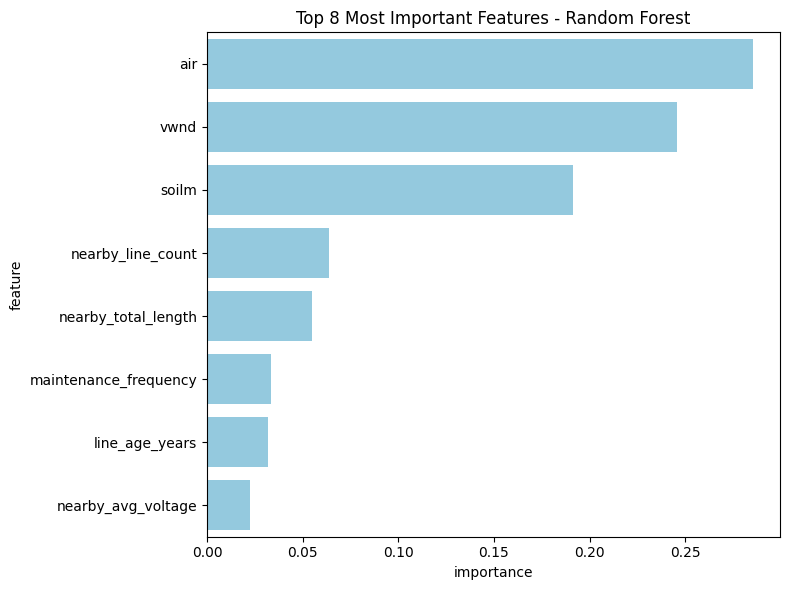


Prediction Distribution:
0    0.713988
1    0.286012
Name: proportion, dtype: float64

Probability Distribution:
count    4797.000000
mean        0.257280
std         0.389547
min         0.000000
25%         0.000000
50%         0.000000
75%         0.661040
max         1.000000
dtype: float64

XGBoost Model Results

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3819
           1       0.63      0.96      0.76       978

    accuracy                           0.88      4797
   macro avg       0.81      0.91      0.84      4797
weighted avg       0.91      0.88      0.88      4797


ROC-AUC Score: 0.9619128017216683


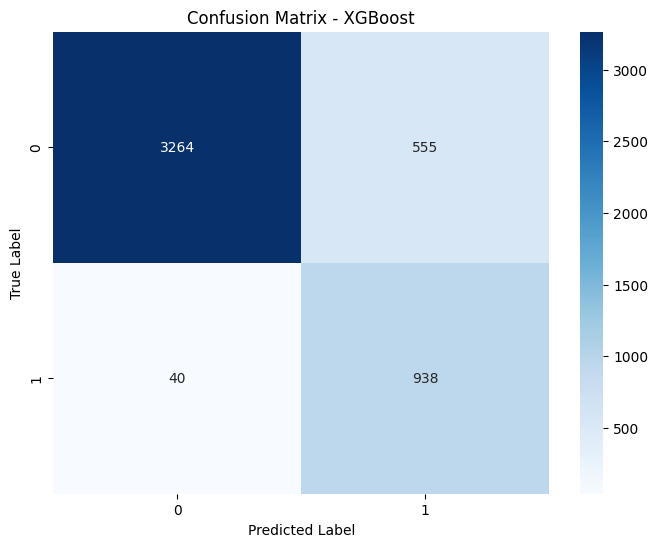

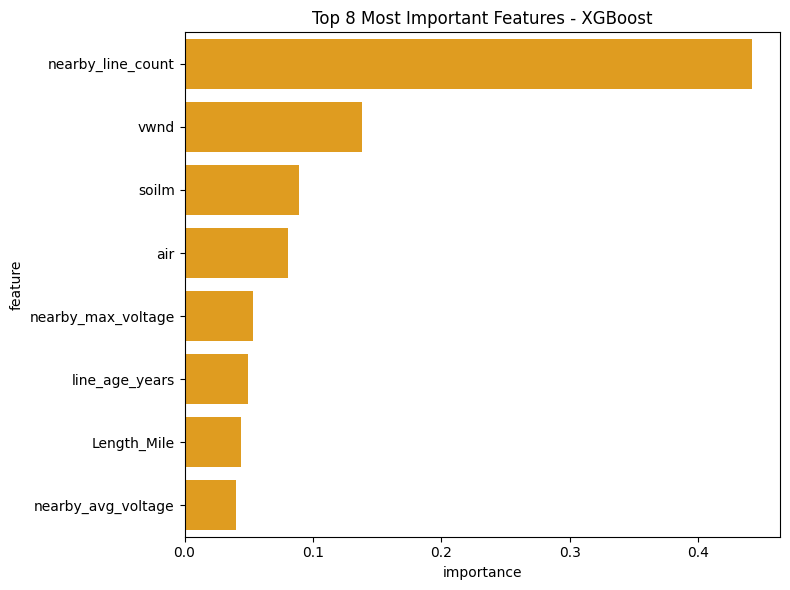


Prediction Distribution:
0    0.688764
1    0.311236
Name: proportion, dtype: float64

Probability Distribution:
count    4797.000000
mean        0.313209
std         0.413051
min         0.000007
25%         0.001446
50%         0.034371
75%         0.854322
max         0.999332
dtype: float64


In [48]:
import seaborn as sns

# Random Forest Detailed Results
print("Random Forest Model Results")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# ROC-AUC Score
print("\nROC-AUC Score:", rf_roc_auc)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature Importance - Random Forest
rf_feature_df = pd.DataFrame(rf_feature_importances, columns=['feature', 'importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=rf_feature_df.head(8), x='importance', y='feature', color='skyblue')
plt.title('Top 8 Most Important Features - Random Forest')
plt.tight_layout()
plt.show()

# Prediction Distribution
print("\nPrediction Distribution:")
print(pd.Series(y_pred_rf).value_counts(normalize=True))

# Probability Thresholds
print("\nProbability Distribution:")
print(pd.Series(y_pred_proba_rf).describe())

# XGBoost Detailed Results
print("\nXGBoost Model Results")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# ROC-AUC Score
print("\nROC-AUC Score:", xgb_roc_auc)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature Importance - XGBoost
xgb_feature_df = pd.DataFrame(xgb_feature_importances, columns=['feature', 'importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=xgb_feature_df.head(8), x='importance', y='feature', color='orange')
plt.title('Top 8 Most Important Features - XGBoost')
plt.tight_layout()
plt.show()

# Prediction Distribution
print("\nPrediction Distribution:")
print(pd.Series(y_pred_xgb).value_counts(normalize=True))

# Probability Thresholds
print("\nProbability Distribution:")
print(pd.Series(y_pred_proba_xgb).describe())


### Additional ML Testing

In [ ]:
# Load the cleaned data
cleaned_data = pd.read_csv('../data/processed/cleaned_data_final.csv')

In [3]:
# Define feature groups
# Define feature groups
spatial_features = [
    'nearby_line_count',
    'min_distance_to_line',
    'avg_distance_to_line'
]  # Removed LATITUDE and LONGITUDE

environmental_features = [
    'air', 'soilm', 'vwnd',
    'EVI_max', 'EVI_mean',
    'NDVI_max', 'NDVI_mean'
]

engineered_features = [
    'log_nearby_lines',
    'has_transmission_line',
    'voltage_distance_interaction',
    'density_voltage_interaction'
]

categorical_features = [
    'voltage_category_High (200-249kV)',
    'voltage_category_Low (<100kV)',
    'voltage_category_Medium (100-199kV)',
    'voltage_category_Very High (250-449kV)',
    'distance_category_<100m',
    'distance_category_>500m',
    'distance_category_Immediate Proximity',
    'season_Spring', 'season_Summer', 'season_Fall',
    'FIRE_SIZE_CLASS_B', 'FIRE_SIZE_CLASS_C', 
    'FIRE_SIZE_CLASS_D', 'FIRE_SIZE_CLASS_E',
    'FIRE_SIZE_CLASS_F', 'FIRE_SIZE_CLASS_G'
]

# Combine all features
features = spatial_features + environmental_features + engineered_features + categorical_features


In [6]:
# Prepare X and y
X = cleaned_data[features]
y = cleaned_data['is_power_related']

# Check for missing values before splitting
print("Missing values in features:")
print(X.isnull().sum()[X.isnull().sum() > 0])

Missing values in features:
min_distance_to_line            78187
avg_distance_to_line            78187
voltage_distance_interaction    78259
density_voltage_interaction     78259
dtype: int64


In [4]:
# Prepare X and y
X = cleaned_data[features]
y = cleaned_data['is_power_related']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
# Train models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42
    )
}


Training Random Forest...

Results for Random Forest:

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     36155
           1       0.03      0.21      0.06       622

    accuracy                           0.88     36777
   macro avg       0.51      0.55      0.50     36777
weighted avg       0.97      0.88      0.92     36777


ROC-AUC Score: 0.5966345108435858


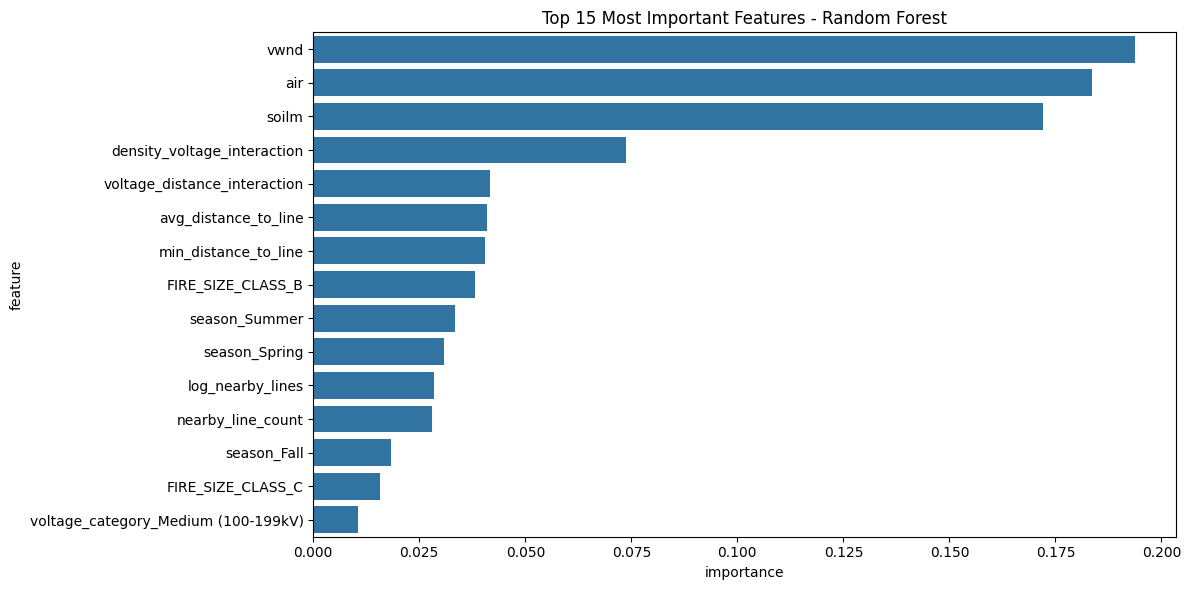


Training XGBoost...

Results for XGBoost:

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85     36155
           1       0.03      0.52      0.06       622

    accuracy                           0.74     36777
   macro avg       0.51      0.63      0.46     36777
weighted avg       0.97      0.74      0.84     36777


ROC-AUC Score: 0.6850542346035136


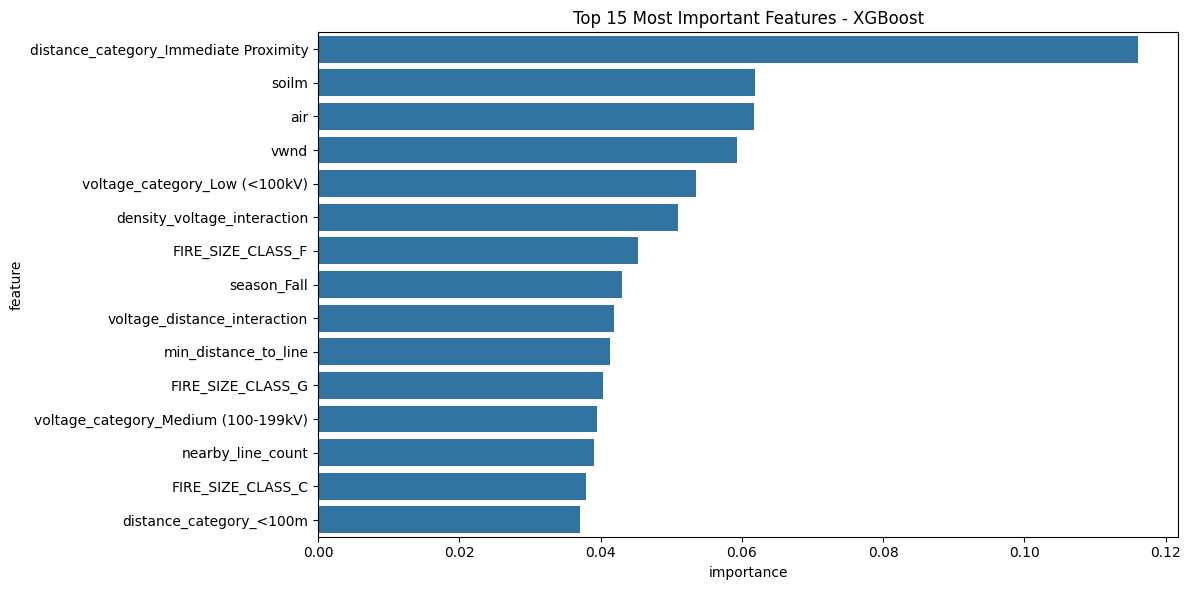

In [38]:
# Train and evaluate models
results = {}
feature_importance_dfs = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Store results
    results[name] = {
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    })
    feature_importance_dfs[name] = feature_importance.sort_values('importance', ascending=False)

    # Print results
    print(f"\nResults for {name}:")
    print("\nClassification Report:")
    print(results[name]['classification_report'])
    print("\nROC-AUC Score:", results[name]['roc_auc'])
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=feature_importance_dfs[name].head(15),
        x='importance',
        y='feature'
    )
    plt.title(f'Top 15 Most Important Features - {name}')
    plt.tight_layout()
    plt.show()

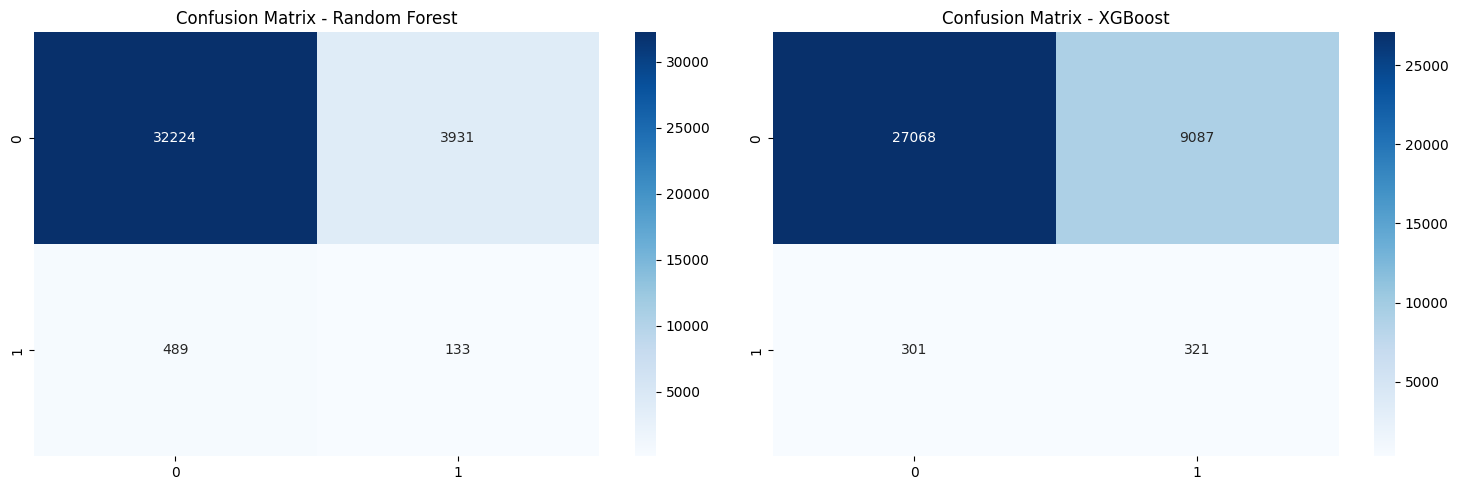

In [39]:

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, (name, result) in enumerate(results.items()):
    sns.heatmap(
        result['confusion_matrix'],
        annot=True,
        fmt='d',
        ax=axes[i],
        cmap='Blues'
    )
    axes[i].set_title(f'Confusion Matrix - {name}')
plt.tight_layout()
plt.show()

In [7]:
# Load and preprocess data
cleaned_data = pd.read_csv('../data/processed/cleaned_data_final.csv')

spatial_features = [
    'nearby_line_count',
    'min_distance_to_line',
    'avg_distance_to_line'
]

environmental_features = [
    'air', 'soilm', 'vwnd',
    'EVI_max', 'EVI_mean',
    'NDVI_max', 'NDVI_mean'
]

engineered_features = [
    'log_nearby_lines',
    'has_transmission_line',
    'voltage_distance_interaction',
    'density_voltage_interaction'
]

categorical_features = [
    'voltage_category_High (200-249kV)',
    'voltage_category_Low (<100kV)',
    'voltage_category_Medium (100-199kV)',
    'voltage_category_Very High (250-449kV)',
    'distance_category_<100m',
    'distance_category_>500m',
    'distance_category_Immediate Proximity',
    'season_Spring', 'season_Summer', 'season_Fall',
    'FIRE_SIZE_CLASS_B', 'FIRE_SIZE_CLASS_C', 
    'FIRE_SIZE_CLASS_D', 'FIRE_SIZE_CLASS_E',
    'FIRE_SIZE_CLASS_F', 'FIRE_SIZE_CLASS_G'
]

# Combine all features
features = spatial_features + environmental_features + engineered_features + categorical_features

# Combine all features
features = spatial_features + environmental_features + engineered_features + categorical_features

# Handle missing values
max_distance = 1000  # Our buffer was 1km
cleaned_data['min_distance_to_line'] = cleaned_data['min_distance_to_line'].fillna(max_distance)
cleaned_data['avg_distance_to_line'] = cleaned_data['avg_distance_to_line'].fillna(max_distance)
cleaned_data['voltage_distance_interaction'] = cleaned_data['voltage_distance_interaction'].fillna(0)
cleaned_data['density_voltage_interaction'] = cleaned_data['density_voltage_interaction'].fillna(0)

# For XGBoost, we need to rename columns to remove special characters
feature_name_mapping = {
    col: col.replace('<', 'less_than').replace('>', 'greater_than').replace('(', '').replace(')', '').replace(' ', '_')
    for col in features
}


/var/folders/4c/0zt2zr712xn0rtz1d_xhxpgm0000gn/T/ipykernel_13056/4267910214.py:2: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_data = pd.read_csv('../data/processed/cleaned_data_final.csv')


In [8]:
# Create copy of data with renamed columns
X = cleaned_data[features].copy()
X.columns = [feature_name_mapping[col] for col in X.columns]
y = cleaned_data['is_power_related']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Training Random Forest...

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.77      0.87     36155
           1       0.03      0.36      0.05       622

    accuracy                           0.77     36777
   macro avg       0.51      0.57      0.46     36777
weighted avg       0.97      0.77      0.85     36777

ROC-AUC Score: 0.6275680228170867


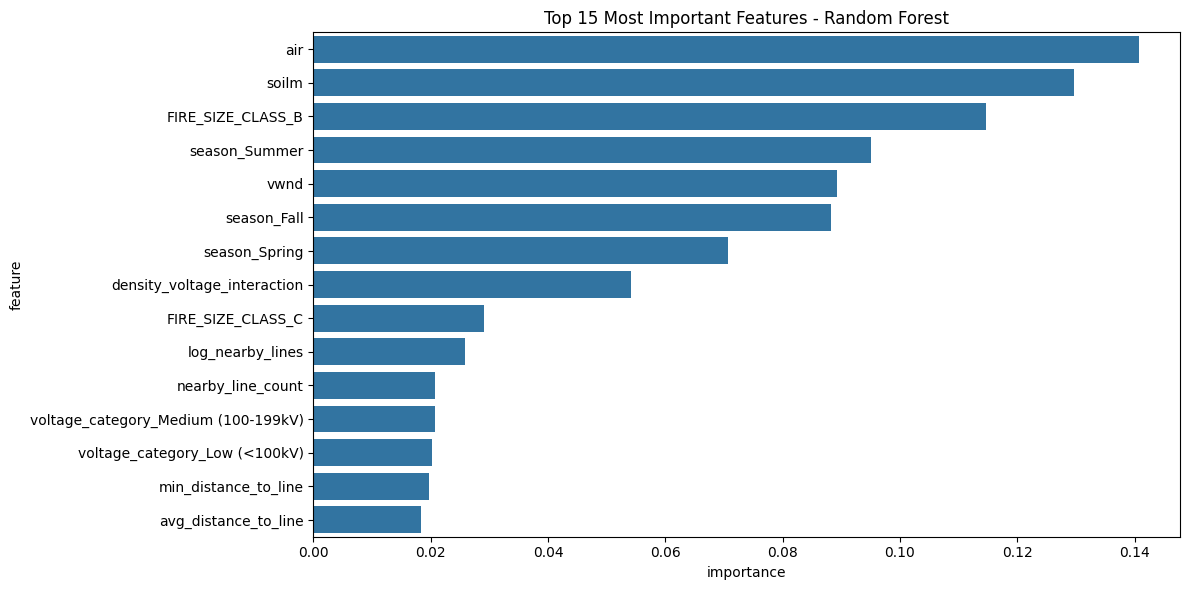


Training XGBoost...

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.02      0.04     36155
           1       0.02      0.99      0.03       622

    accuracy                           0.04     36777
   macro avg       0.51      0.51      0.04     36777
weighted avg       0.98      0.04      0.04     36777

ROC-AUC Score: 0.6032234826739641


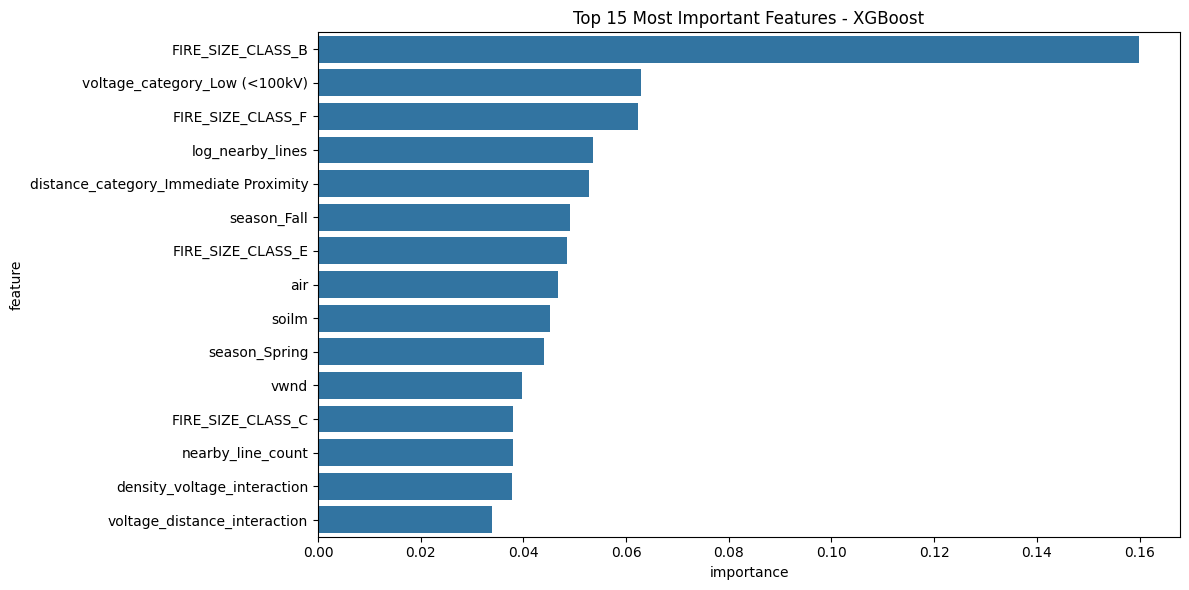

In [9]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Create pipeline with SMOTE
rf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        max_depth=10,
        min_samples_leaf=5,
        random_state=42
    ))
])

xgb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(
        scale_pos_weight=50,
        max_depth=6,
        min_child_weight=1,
        gamma=0.1,
        learning_rate=0.01,
        n_estimators=200,
        random_state=42
    ))
])

# Train and evaluate models
models = {
    'Random Forest': rf_pipeline,
    'XGBoost': xgb_pipeline
}

for name, pipeline in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Print results
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
    
    # Feature importance
    if name == 'Random Forest':
        importances = pipeline.named_steps['classifier'].feature_importances_
    else:
        importances = pipeline.named_steps['classifier'].feature_importances_
    
    # Map back to original feature names for visualization
    reverse_mapping = {v: k for k, v in feature_name_mapping.items()}
    feature_imp = pd.DataFrame({
        'feature': [reverse_mapping.get(col, col) for col in X.columns],
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_imp.head(15), x='importance', y='feature')
    plt.title(f'Top 15 Most Important Features - {name}')
    plt.tight_layout()
    plt.show()

Training XGBoost with modified parameters...

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     36155
           1       0.05      0.10      0.07       622

    accuracy                           0.95     36777
   macro avg       0.52      0.54      0.52     36777
weighted avg       0.97      0.95      0.96     36777


ROC-AUC Score: 0.6746121668895222


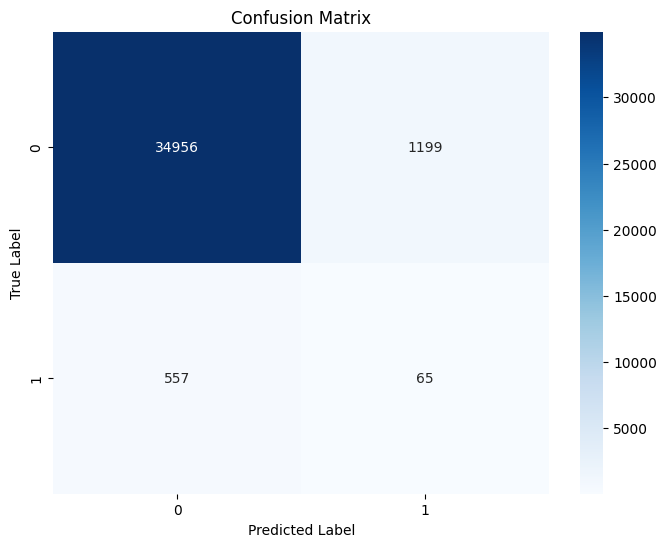

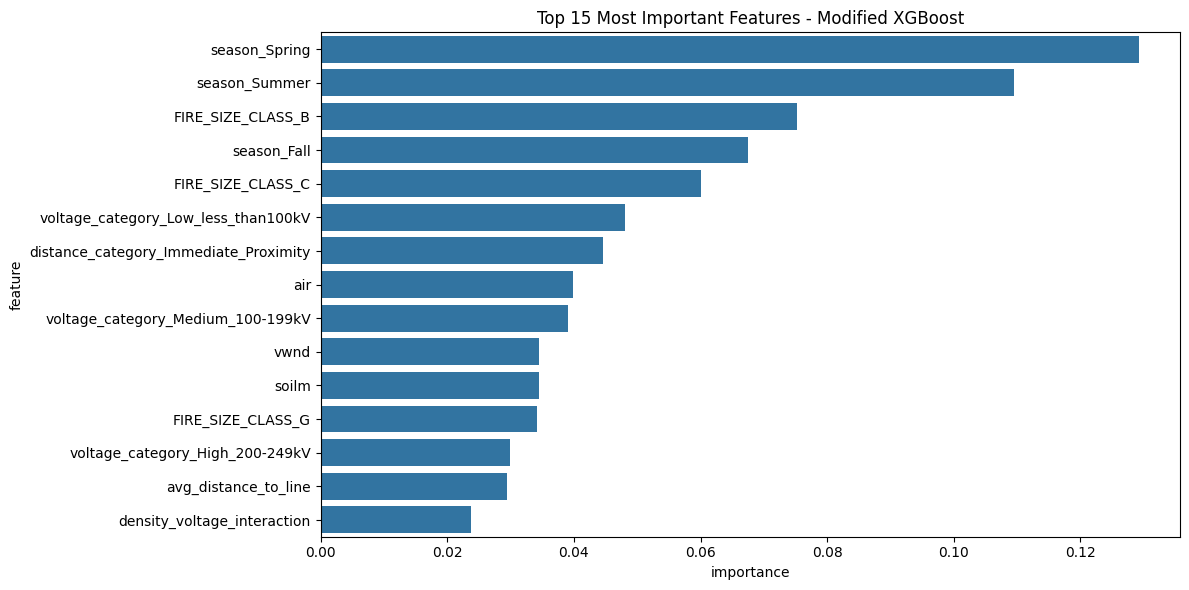


Prediction Distribution:
0    0.965631
1    0.034369
Name: proportion, dtype: float64

Probability Distribution:
count    36777.000000
mean         0.220583
std          0.133225
min          0.005447
25%          0.115872
50%          0.197207
75%          0.301862
max          0.933658
dtype: float64


In [13]:
# Modified XGBoost parameters
xgb_classifier = xgb.XGBClassifier(
    scale_pos_weight=5,  # Reduced from 50
    max_depth=4,         # Reduced from 6
    min_child_weight=3,  # Increased from 1
    gamma=0.3,          # Increased from 0.1
    learning_rate=0.2,   # Increased from 0.01
    n_estimators=100,    # Reduced from 200
    subsample=0.8,       # Added subsampling
    colsample_bytree=0.8,# Added column sampling
    random_state=42
)

# Create pipeline with modified SMOTE
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42, sampling_strategy=0.1)),  # Reduced minority class oversampling
    ('scaler', StandardScaler()),  # Added scaling
    ('classifier', xgb_classifier)
])

# Train and evaluate
print("Training XGBoost with modified parameters...")
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Print detailed results
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_prob))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance
importances = pipeline.named_steps['classifier'].feature_importances_
feature_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_imp.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features - Modified XGBoost')
plt.tight_layout()
plt.show()

# Print additional metrics
print("\nPrediction Distribution:")
print(pd.Series(y_pred).value_counts(normalize=True))

# Calculate probability thresholds
probabilities = pipeline.predict_proba(X_test)[:, 1]
print("\nProbability Distribution:")
print(pd.Series(probabilities).describe())


Training model_1...

Results for model_1:
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     36155
           1       0.36      0.01      0.01       622

    accuracy                           0.98     36777
   macro avg       0.67      0.50      0.50     36777
weighted avg       0.97      0.98      0.97     36777

ROC-AUC Score: 0.7024986426341391


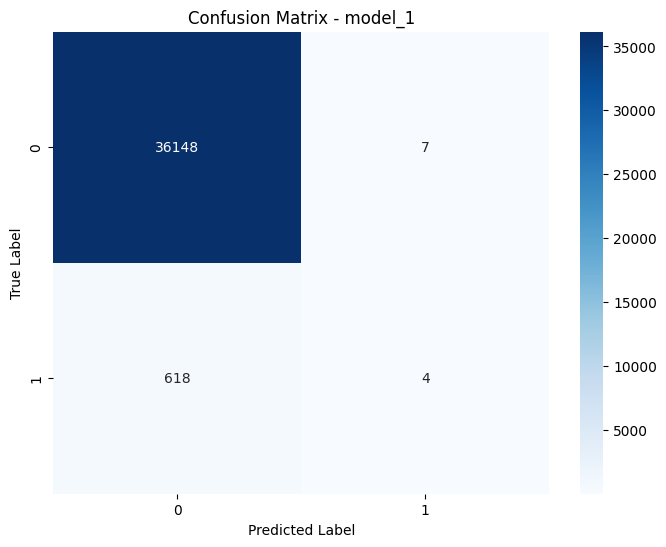

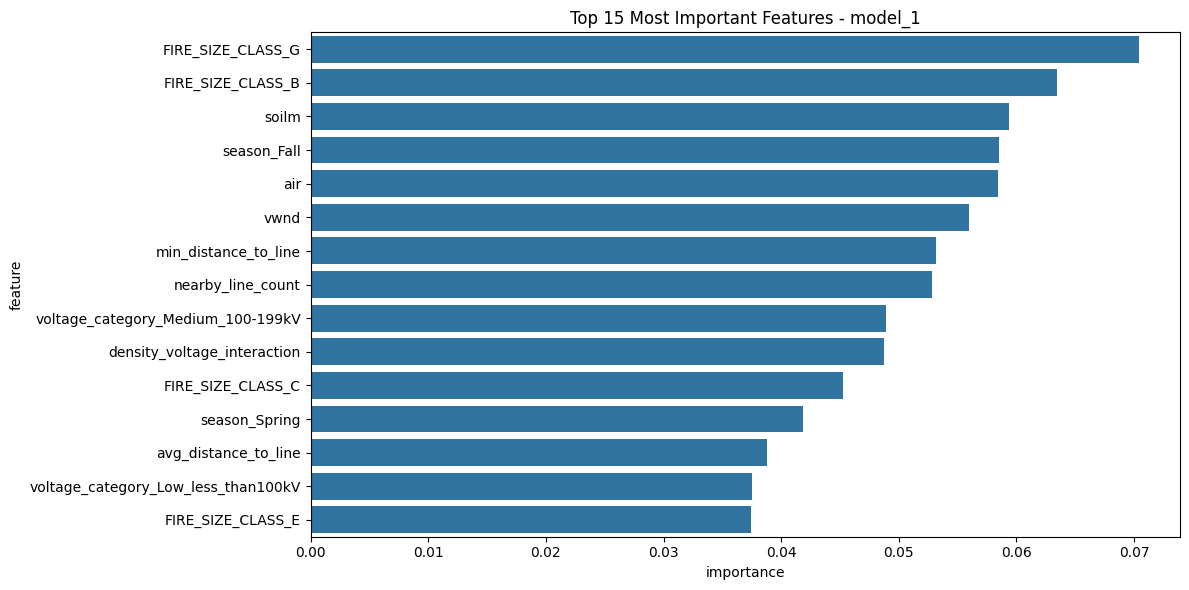


Training model_2...

Results for model_2:
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     36155
           1       0.40      0.01      0.02       622

    accuracy                           0.98     36777
   macro avg       0.69      0.51      0.51     36777
weighted avg       0.97      0.98      0.98     36777

ROC-AUC Score: 0.705005333858641


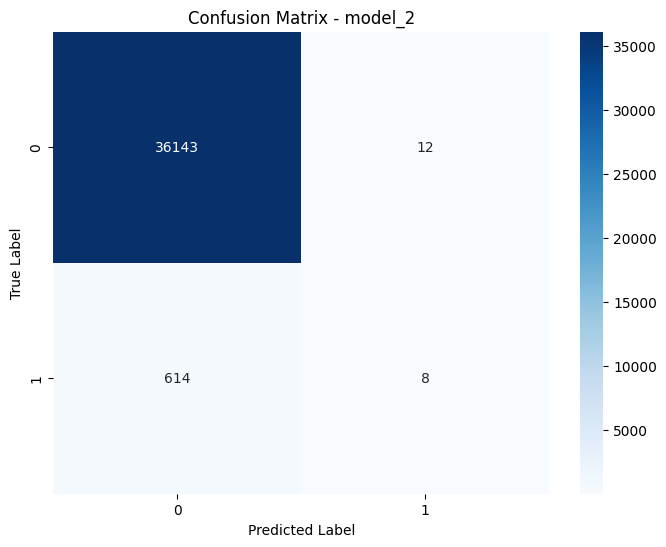

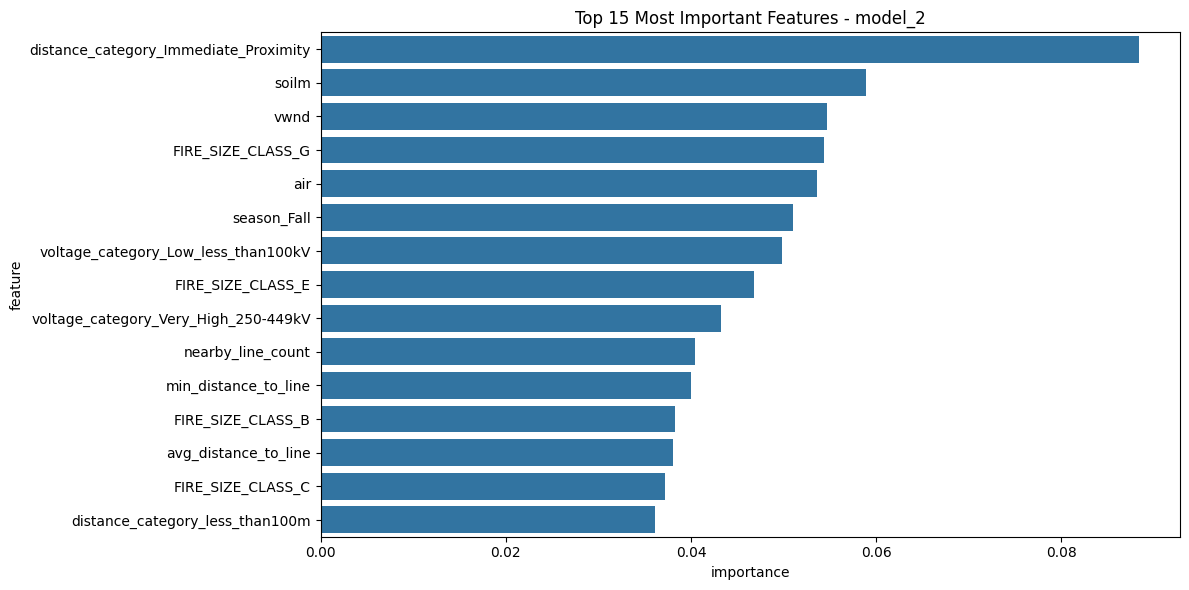


Training model_3...

Results for model_3:
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     36155
           1       0.23      0.01      0.02       622

    accuracy                           0.98     36777
   macro avg       0.60      0.51      0.51     36777
weighted avg       0.97      0.98      0.97     36777

ROC-AUC Score: 0.7010523865404445


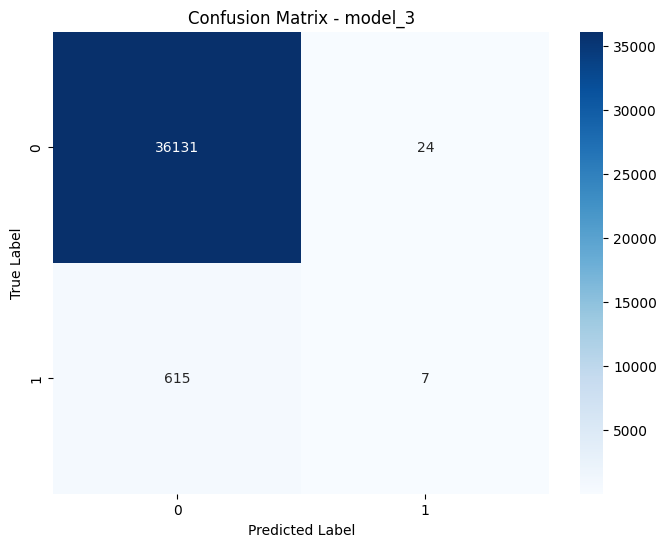

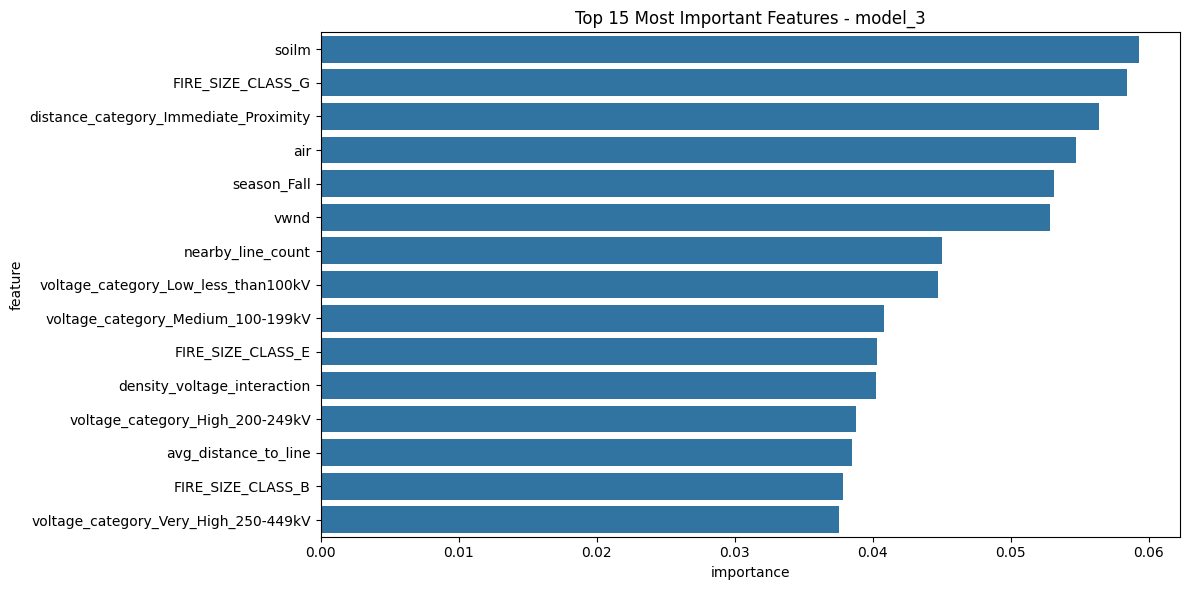

NameError: name 'roc_auc' is not defined

<Figure size 800x600 with 0 Axes>

In [15]:
# Define several XGBoost configurations to try
xgb_configs = {
    'model_1': xgb.XGBClassifier(
        scale_pos_weight=3,      # Further reduced to be less aggressive
        max_depth=3,             # Slightly reduced to prevent overfitting
        min_child_weight=3,
        gamma=0.3,
        learning_rate=0.2,
        n_estimators=150,        # Increased slightly
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    'model_2': xgb.XGBClassifier(
        scale_pos_weight=4,
        max_depth=4,
        min_child_weight=2,      # Slightly reduced
        gamma=0.4,               # Increased slightly
        learning_rate=0.15,      # Reduced slightly
        n_estimators=120,
        subsample=0.85,          # Slightly increased
        colsample_bytree=0.85,
        random_state=42
    ),
    'model_3': xgb.XGBClassifier(
        scale_pos_weight=5,      # Your original value
        max_depth=4,
        min_child_weight=3,
        gamma=0.25,              # Slightly reduced
        learning_rate=0.18,      # Slightly reduced
        n_estimators=100,
        subsample=0.75,          # Slightly reduced
        colsample_bytree=0.75,
        random_state=42
    )
}

# Train and evaluate each model
results = {}
for name, model in xgb_configs.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'classification_report': classification_report(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'feature_importance': pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
    }
    
    print(f"\nResults for {name}:")
    print("Classification Report:")
    print(results[name]['classification_report'])
    print("ROC-AUC Score:", results[name]['roc_auc'])
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(results[name]['confusion_matrix'], 
                annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=results[name]['feature_importance'].head(15),
        x='importance',
        y='feature'
    )
    plt.title(f'Top 15 Most Important Features - {name}')
    plt.tight_layout()
    plt.show()

# Compare ROC curves
plt.figure(figsize=(8, 6))
for name, result in results.items():
    y_prob = xgb_configs[name].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_auc(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

Training CatBoost...
0:	learn: 0.5967046	test: 0.5968544	best: 0.5968544 (0)	total: 68.2ms	remaining: 6.75s
1:	learn: 0.5229754	test: 0.5231588	best: 0.5231588 (1)	total: 79.3ms	remaining: 3.89s
2:	learn: 0.4663519	test: 0.4665746	best: 0.4665746 (2)	total: 89.6ms	remaining: 2.9s
3:	learn: 0.4233617	test: 0.4236350	best: 0.4236350 (3)	total: 99.7ms	remaining: 2.39s
4:	learn: 0.3899988	test: 0.3904089	best: 0.3904089 (4)	total: 109ms	remaining: 2.07s
5:	learn: 0.3638817	test: 0.3645740	best: 0.3645740 (5)	total: 119ms	remaining: 1.86s
6:	learn: 0.3441246	test: 0.3449213	best: 0.3449213 (6)	total: 129ms	remaining: 1.71s
7:	learn: 0.3290983	test: 0.3299706	best: 0.3299706 (7)	total: 139ms	remaining: 1.6s
8:	learn: 0.3169497	test: 0.3179488	best: 0.3179488 (8)	total: 150ms	remaining: 1.51s
9:	learn: 0.3072920	test: 0.3085110	best: 0.3085110 (9)	total: 161ms	remaining: 1.45s
10:	learn: 0.2996101	test: 0.3009492	best: 0.3009492 (10)	total: 172ms	remaining: 1.39s
11:	learn: 0.2940915	test: 0.

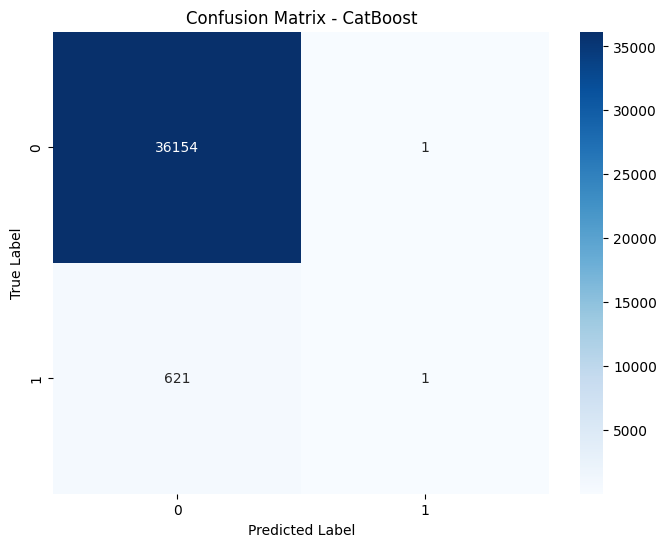

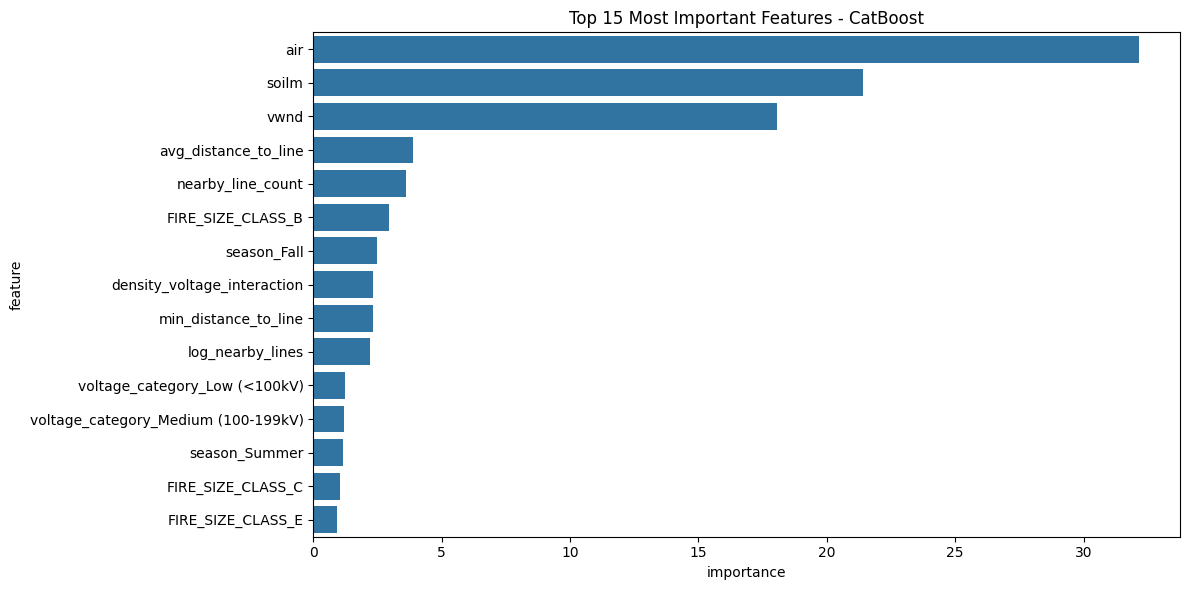

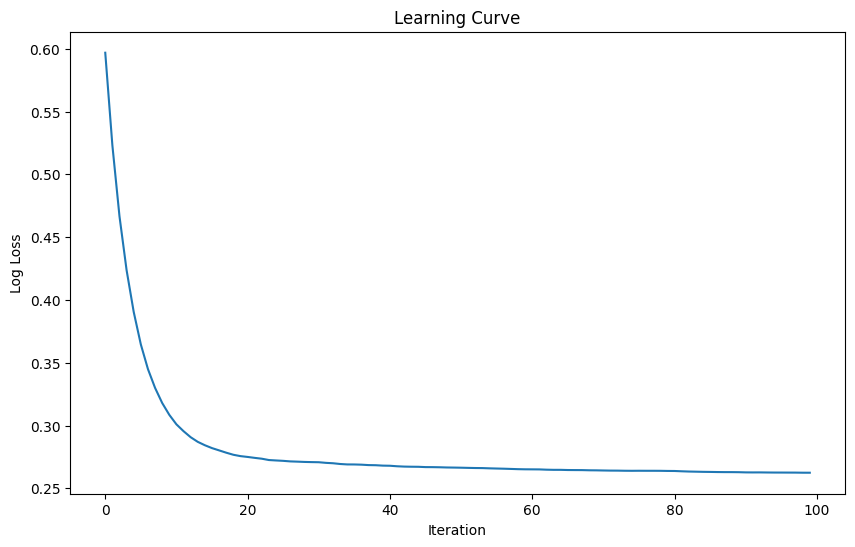

In [17]:
from catboost import CatBoostClassifier
# Initialize CatBoost classifier
catboost_classifier = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=4,
    l2_leaf_reg=3,
    loss_function='Logloss',
    class_weights={0: 1, 1: 5},  # Similar to scale_pos_weight
    random_seed=42,
    verbose=True
)

# Train the model
print("Training CatBoost...")
catboost_classifier.fit(X_train, y_train, eval_set=(X_test, y_test))

# Make predictions
y_pred = catboost_classifier.predict(X_test)
y_prob = catboost_classifier.predict_proba(X_test)[:, 1]

# Print results
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_prob))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CatBoost')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': catboost_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features - CatBoost')
plt.tight_layout()
plt.show()

# Learning curves
plt.figure(figsize=(10, 6))
plt.plot(catboost_classifier.get_evals_result()['validation']['Logloss'])
plt.title('Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.show()